In [156]:
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import bokeh 
import pandas as pd
import scipy.stats as st

In [157]:
#función para aplicar filtro de mediana a imagen con ruido
def f1_imr(imagen):
    img_original=cv2.imread(imagen)
    img_filtrada=cv2.medianBlur(img_original,3)

    df_imagen    = pd.DataFrame({
    "valor": np.concatenate([img_original.flatten(),img_filtrada.flatten()]),
     "Imagen": ["Con ruido"]*len(img_original.flatten())+["Filtro Mediana"]*len(img_filtrada.flatten())
})

    
    return img_original, img_filtrada, df_imagen

#función para aplicar binarización manual y de Otsu
def f2_imr(imagenF,cotainferior,cotasuperior):
    #binarización manual con cotas obtenidas a través del histograma
    img_manual=np.where(( (imagenF>cotainferior) & (imagenF<cotasuperior)) ,imagenF,0)

    #binarización de Otsu para imagen sin ruido
    ret_otsu0,img_otsu0 =cv2.threshold(cv2.cvtColor(imagenF, cv2.COLOR_BGR2GRAY),0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #binarización de Otsu sobre el resultado de binarización manual
    ret_otsu1,img_otsu1 =cv2.threshold(cv2.cvtColor(img_manual, cv2.COLOR_BGR2GRAY),0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img_manual, ret_otsu0, img_otsu0,ret_otsu1, img_otsu1
    
    

In [158]:
#Cargar imagen a trabajar

#!!!!modificar con ruta de trabajo local!!!!
ruta_dir='C:/Users/leona/Documents/doc IA/computational mathematics'
os.chdir(ruta_dir)

#!!!!Para el correcto funcionamiento sólo utilizar una línea de imagen a la vez!!!!
imagen="noisy_25.png"
#imagen="noisy_40.png"
#imagen="noisy_50.png"

imagenSE = imagen.replace(".png", "") #para extraer nombre de la imagen sin extensión .png

In [159]:
import cv2
import numpy as np
import requests
from io import BytesIO

# URL de la imagen en GitHub
url = "https://github.com/leomanriquezm/Image-processing/blob/main/noisy_50.png"

# Descargar la imagen desde la URL
response = requests.get(url)
img_bytes = BytesIO(response.content)

# Leer la imagen usando OpenCV
img_original = cv2.imdecode(np.frombuffer(img_bytes.read(), np.uint8), cv2.IMREAD_COLOR)


In [160]:
#aplica función de filtro de mediana 
imagen_original,imagen_filtrada,df_imagen = f1_imr(imagen)

Replica de Figura 1 (a)


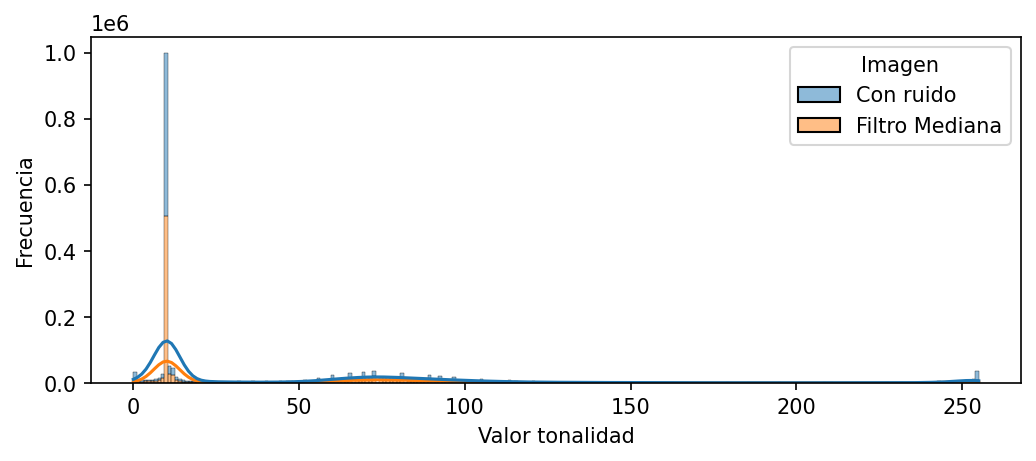

In [161]:
#resultado de histograma de imagen original vs imagen suavizada

plt.figure(figsize=(8, 3), dpi=150)
sns.histplot(data=df_imagen, x='valor', hue='Imagen', kde=True, multiple='stack')
plt.ylabel("Frecuencia")
plt.xlabel("Valor tonalidad")

plt.savefig(f"res_hist_{imagenSE}.png", dpi=150, bbox_inches='tight')
print("Replica de Figura 1 (a)")
plt.show()


Replica Figura 2


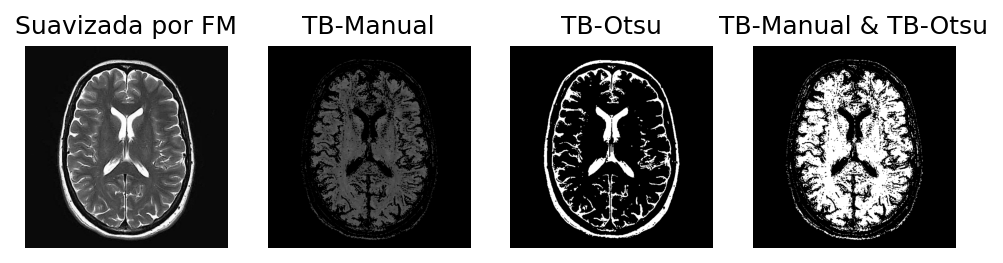

In [162]:
#aplicación de función de binarización. Considera los casos de los umbrales de las diferentes imágenes utilizadas: 25, 40 Y 50

if imagen == "noisy_50.png":
    imagen_bmanual, ret_otsu0, imagen_botsu0, ret_otsu1, imagen_botsu1 = f2_imr(imagen_filtrada, 100, 150)
elif imagen == "noisy_25.png":
    imagen_bmanual, ret_otsu0, imagen_botsu0, ret_otsu1, imagen_botsu1 = f2_imr(imagen_filtrada, 60, 100)
elif imagen == "noisy_40.png":
    imagen_bmanual, ret_otsu0, imagen_botsu0, ret_otsu1, imagen_botsu1 = f2_imr(imagen_filtrada, 45, 70)
else:
    print("Imagen no reconocida.")


plt.figure(figsize=(8, 6), dpi=150)
plt.subplot(1, 4, 1)
plt.imshow(imagen_filtrada, cmap='gray')
plt.title('Suavizada por FM')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imagen_bmanual, cmap='gray')
plt.title('TB-Manual')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imagen_botsu0, cmap='gray')
plt.title('TB-Otsu')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imagen_botsu1, cmap='gray')
plt.title('TB-Manual & TB-Otsu')
plt.axis('off')


plt.savefig(f"res_cerebro_{imagenSE}.png", dpi=150, bbox_inches='tight')
print("Replica Figura 2")
plt.show()

Replica Figura 1 (b)


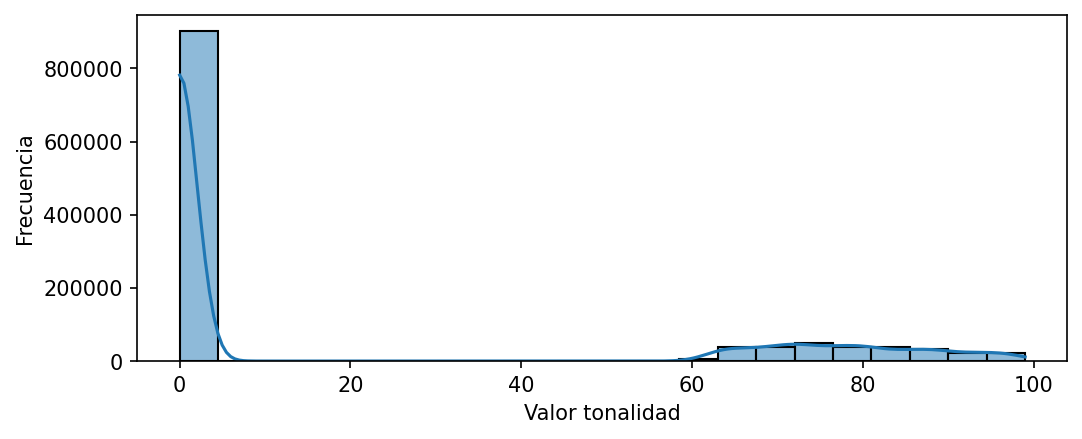

In [163]:
#Histograma de la binarización manual

plt.figure(figsize=(8, 3), dpi=150)
sns.histplot(imagen_bmanual.flatten(),kde=True, multiple='stack')
plt.ylabel("Frecuencia")
plt.xlabel("Valor tonalidad")
plt.savefig(f"res_hist_TBM_{imagenSE}.png", dpi=150, bbox_inches='tight')
print("Replica Figura 1 (b)")
plt.show()


In [164]:
#tabla resumen de las tonaldiades de las imagenes. En el documento se utilizan las columnas Imagen, Media e Intervalos de confianza

df_img = pd.DataFrame({
    "valor": np.concatenate([imagen_filtrada.flatten(),imagen_bmanual.flatten(),imagen_botsu0.flatten(),imagen_botsu1.flatten()]),
     "Imagen": ["F.Mediana"]*len(imagen_filtrada.flatten())+["B. Manual"]*len(imagen_bmanual.flatten())+["B. Otsu0"]*len(imagen_botsu0.flatten())+["B. Otsu1"]*len(imagen_botsu1.flatten())
})

def int_conf(media, std, n, confidence=0.95):
    t_critical = st.t.ppf((1 + confidence) / 2, df=n-1) 
    margin_of_error = t_critical * (std / np.sqrt(n))  
    return media - margin_of_error, media + margin_of_error

result = df_img.groupby('Imagen')['valor'].agg(
    Media=lambda x: x.mean(),
    Mediana=lambda x: x.median(),
    Desviación=lambda x: x.std(),
    Cuartil_25=lambda x: x.quantile(0.25),
    Cuartil_75=lambda x: x.quantile(0.75),
    Observaciones=lambda x: len(x)
).reset_index()

result[['IC_inf', 'IC_sup']] = result.apply(
    lambda row: int_conf(row['Media'], row['Desviación'], row['Observaciones']),
    axis=1, result_type="expand"
)
print("Replica Cuadro 1")
print(result.round(2))

Replica Cuadro 1
      Imagen  Media  Mediana  Desviación  Cuartil_25  Cuartil_75  \
0  B. Manual  19.03      0.0       34.00         0.0         0.0   
1   B. Otsu0  27.53      0.0       79.14         0.0         0.0   
2   B. Otsu1  61.83      0.0      109.29         0.0         0.0   
3  F.Mediana  52.94     12.0       62.10        10.0        80.0   

   Observaciones  IC_inf  IC_sup  
0        1190700   18.97   19.09  
1         396900   27.28   27.78  
2         396900   61.49   62.17  
3        1190700   52.83   53.05  
